# Random Walks on different networks

## Approach

- Take lattice from graph library and implement MC algorithm 
    - Check for correct behaviour, e.g. diffsuion, end-to-end-distance, every node visited, … 

- Test on other graphs, introduce chaos 
    - Start with lattice and take away nodes 
    - Introduce long range connections to 2d-lattice
    
### Random walk 
- standard Random walk 
    - Move to any adjacent node with equal probability 
- Lazy random walk 
    - Prob ½ to stay, prob ½ to move (equally distributed over adjacent nodes) 

Problems: 
- Measure for distance in a graph with additional edges? 
    -> If we stick with a lattice, we can define our own underlying distance function d(u,v) 
- Walk only to right and distance gets smaller again 

## Code

In [47]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, fixed
%matplotlib inline
import matplotlib.pyplot as plt

### Lattice graph in networkx

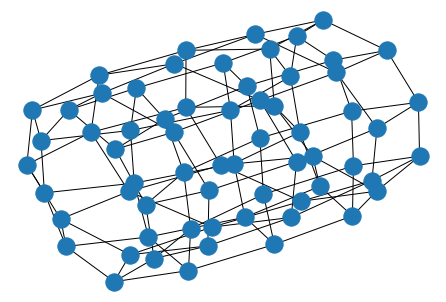

In [38]:
# 2d lattice graph, periodic
L = 8
G = nx.grid_2d_graph(L,L, periodic=True)

# plot
nx.draw(G)

In [39]:
# all nodes have degree 4
nx.degree_histogram(G)

[0, 0, 0, 0, 64]

In [40]:
'''
    Lattice sites are enumerated (row, column) starting on
    upper left with (0,0) ending on lower right with (7,7).
'''
# example: neighbours of node (0,0) and (1,1)
print(list(nx.neighbors(G, (0,0))),'\t', list(nx.neighbors(G, (1,1))))

[(1, 0), (0, 1), (7, 0), (0, 7)] 	 [(0, 1), (2, 1), (1, 0), (1, 2)]


### Starting with random walks

#### Distance functions

In [41]:
def dist_1d(a, b, L):
    '''
    Distance between two points on a periodic 
    line with length L.
    
    Arguments:
    - a: first point (integer 0,..,L-1)
    - b: second point (integer 0,...,L-1)
    - L: number of points on line
    
    Return:
    - d: distance between points
    '''
    # handle usage of bad arguments
    if a>=L or b>=L or a<0 or b<0:
        print('INFO: \na={} or b={} should be in range [0,L-1]=[0,{}]. Using a%L={} or b%L={} instead.\n'.format(a, b, L, a%L, b%L))
        a = a%L
        b = b%L
    if type(a) != int or type(b) != int or type(L) != int:
        print('INFO: \nAll arguments should be type int. You used type(a)={}, type(b)={}, type(L)={}. \nWill be converted using int(..).\n'.format(type(a), type(b), type(L)))
        a, b, L = int(a), int(b), int(L)
        
    # return distance
    d = 0
    if abs(a-b)<L/2.:
        d = abs(a-b)
    else :
        d = L-abs(a-b)
    return d


def dist_2d_lattice(u, v, L):
    '''
    Distance between two node on a periodic 
    lattice graph with side length L.
    
    Arguments:
    - u: first node (tuple (u_0, u_1))
    - v: second node (tuple (v_0, v_1))
    - L: side length of lattice
    
    Return:
    - d: distance between points (-1 if error occured)
    '''
    # handle arguments having wrong types
    if type(u)!=tuple or type(v)!= tuple:
        print('ERROR: \nArguments u and v should be type tuple. You used type(u)={}, type(v)={}. \nBreak and return -1\n'.format(type(u), type(v)))
        return -1
    if type(L)!=int:
        print('INFO: \nArgument L should be type int. You used type(L)={}. Now using int(L)={}\n'.format(type(L), int(L)))
        L=int(L)
    
    d = dist_1d(u[0], v[0], L) + dist_1d(u[1], v[1], L)
    return d

#### Checking our 2d lattice distance and nx.shortest_path_length() algorithm for similar results

In [42]:
u = (0,0)
v = (4,4)
# compare measures

print('Distance between nodes u={}, v={} on 2d lattice graph G with side length L={}'.format(u, v, L),
      '\n\nUsing dist_2d_lattice():', dist_2d_lattice(u,v,L),
      '\nUsing nx.shortest_path_length() on G:', nx.shortest_path_length(G, source=u, target=v))

Distance between nodes u=(0, 0), v=(4, 4) on 2d lattice graph G with side length L=8 

Using dist_2d_lattice(): 8 
Using nx.shortest_path_length() on G: 8


#### Simple random walk function

In [49]:
def simple_2d_random_walk(G, L, max_steps, start_node=(0,0), use_random_starting_node=False):
    '''
    Perform a simple random walk on a given graph G, which should be based on a 2d lattice.
    In one step the random walker with equal probability traverses any of the incident edges 
    of the current node to a neighboring node. 
    
    Arguments:
    - G: graph, based on a 2d lattice
    - L: side length L of the 2d lattice base of G
    - max_steps: number of steps the random walker takes in total
    - start_node: node to start random walk from, default=(0,0)
    - use_random_starting_node: start on a randomly chosen node, default=False
    
    Return:
    - path: list of edges the random walker traversed (format: [(node1, node2), (node2, node3)])
    '''
    if use_random_starting_node:
        current_node = tuple(np.random.randint(0, L, 2))
    else:
        current_node = start_node
        
    path=[]
    # for-loop over max_steps
    for t in range(max_steps):
        # randomly choose from neighbors of current node
        new_node = tuple(np.random.permutation(list(G[current_node].keys()))[0])
        # append new node to path
        path.append((current_node, new_node))
        current_node = new_node
    return path

#### Draw simple random walk

In [50]:
def plot_walk(G, L, total_path, steps=-1):
    # take only specified steps of path (-1 -> complete path)
    path = total_path[:steps]
    # color map
    color_map=[]
    for node in G:
        if node == path[0][0]:
            color_map.append('red') #INITIAL POINT RED
        elif node == path[-1][1]: 
            color_map.append('blue') #END POINT BLUE
        else:
            color_map.append('lightgreen')

    # FIGURE
    plt.figure(figsize=(6,6))
    # make graph R to display the path
    R = nx.grid_2d_graph(L,L,periodic=True)
    R.remove_edges_from(list(R.edges))
    R.add_edges_from(path)
    pos = {(x,y):(y,-x) for x,y in G.nodes()}
    # draw underlying network
    nx.draw(G, pos=pos, 
        node_color='lightgreen', 
        edge_color='lightgray',
        with_labels=False,
        node_size=100,
        width=3)
    # draw path using R
    nx.draw(R, pos=pos, 
        node_color=color_map, 
        with_labels=False,
        node_size=100,
        edge_color='red',
        width=2)

In [51]:
# T steps of random walk
# always same starting point (0,0)
L=10 # lattice side length
T=100 # steps
G = nx.grid_2d_graph(L, L, periodic=True)

path = simple_2d_random_walk(G, L, T, use_random_starting_node=False)

# plot interactive walk
interact(plot_walk, G=fixed(G), L=fixed(L), total_path=fixed(path), steps=(1, len(path)))

interactive(children=(IntSlider(value=1, description='steps', min=1), Output()), _dom_classes=('widget-interac…

<function __main__.plot_walk(G, L, total_path, steps=-1)>

#### Interactive graph plots

In [48]:
from ipywidgets import interact
%matplotlib inline
import matplotlib.pyplot as plt

def plot(N):
    g = nx.grid_2d_graph(N,N)
    plt.figure(figsize=(6,6))
    pos = {(x,y):(y,-x) for x,y in g.nodes()}
    nx.draw(g, pos=pos, 
        node_color='lightgreen', 
        with_labels=False,
        node_size=100)
    print('Number of edges created =',nx.number_of_edges(g), 'on the total possible = ', N*N*(N*N-1)/2)

interact(plot, N=(2,20), r=(0,4,0.5));

interactive(children=(IntSlider(value=11, description='N', max=20, min=2), Output()), _dom_classes=('widget-in…